In [2]:
from selenium import webdriver
import pandas as pd
import nltk
from collections import Counter 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import string
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
import string
import operator
import io
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup

# Scraper Engine

In [3]:
# Create Necessary DataFrame
df = pd.DataFrame(columns=['date', 'message'])

# Loop through pages
for i in range(1, 350):
    url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p" + str(i)
    
    # Fetch the page content
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all comment blocks on the page
    comments = soup.find_all('li', class_='Item ItemComment noPhotoWrap Role_Member pageBox')
    
    for comment in comments:
        # Extract the date
        date = comment.find('time')
        date_text = date['datetime'] if date else None
        
        # Extract the message content
        message_div = comment.find('div', class_='Message userContent')
        
        if message_div:
            # Remove blockquotes (replies to comments)
            for blockquote in message_div.find_all('blockquote'):
                blockquote.decompose()
            
            # Get the cleaned text
            message_text = message_div.get_text(separator="\n", strip=True)
            
            # Append to the DataFrame
            #df = df.append({'date': date_text, 'message': message_text}, ignore_index=True)
            new_row = pd.DataFrame({'date': [date_text], 'message': [message_text]})

            # Concatenate the new row with the existing DataFrame
            df = pd.concat([df, new_row], ignore_index=True)

In [4]:
# Remove messages with empty string
df = df[df['message'] != '']
#Convert date to MM/DD/YYYY
df['date'] = pd.to_datetime(df['date']).dt.strftime('%m/%d/%Y')

In [5]:
df

,date,message
0,03/25/2002,I am debating a new purchase and these two are...
1,03/25/2002,And no manual tranny. That may not matter to y...
2,03/26/2002,"good grief, so you wait 9 months for the manua..."
3,03/26/2002,I understand it's not about the speed. I reall...
4,03/27/2002,Is there such a thing as an automatic-only tru...
...,...,...
8489,08/27/2014,I tried using the maps on my iPhone but couldn...
8490,08/27/2014,"Now I'm not too sure how Audi or MB does it, b..."
8491,08/27/2014,I have 8 days left- spread out over the next 4...
8492,08/27/2014,"Yeah, I had that in my previous BMW and used t..."


In [6]:
# Download to CSV
df.to_csv('edmunds_scraper.csv', index=False)

## Task A
- Does the data support Zipf’s law econometrically?
- Plot the most common 100 words in the data against the theoretical prediction of the law.

In [7]:
# Does the data support Zipf's law?
# Plot the top 100 words against teoretical Zipf's law
top_words = df['message'].str.split(expand=True).stack().value_counts()[:100]

top_words

the        42357
a          22036
to         17889
and        17488
I          17327
           ...  
could        961
--           953
driving      953
who          941
most         937
Name: count, Length: 100, dtype: int64

### Does it follow zipf's law?
It appears, based on our sample of just 100 words, that this data is following Zipf's law. Notice how when comparing the ratio of the second ranked word "A" to the firs ranked word "THE", the proportion is close to half.
- $$ \frac{16.445}{30.961} = 0.53 $$

Likewise, when comparing the third ranked word "TO" with "THE", we get a value close to a third. The ratio of around 0.43 is reasonably close, especially given the small sample size.

- $$ \frac{13.225}{30.961} = 0.43 $$

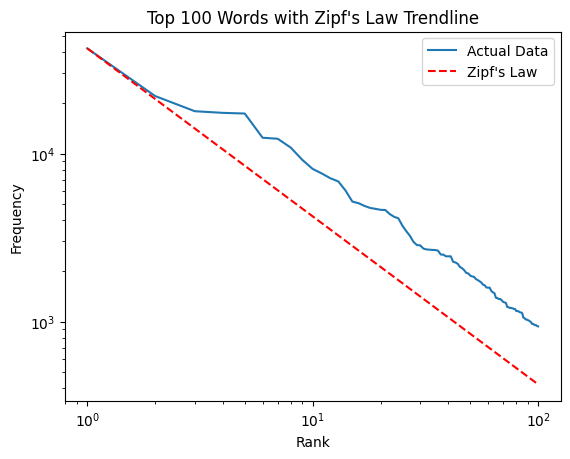

In [8]:
# Plot the top 100 words against teoretical Zipf's law
top_words = df['message'].str.split(expand=True).stack().value_counts()[:100]

# Rank of the words
ranks = np.arange(1, 101)

# Calculate the theoretical Zipf's Law frequencies
# The first word's frequency is the baseline
baseline = top_words.values[0]
theoretical_zipf = baseline / ranks

# Plot the actual data
plt.plot(ranks, top_words.values, label='Actual Data')

# Plot the theoretical Zipf's Law line
plt.plot(ranks, theoretical_zipf, linestyle='--', color='red', label='Zipf\'s Law')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Top 100 Words with Zipf\'s Law Trendline')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Our plot clearly demonstrates that the word frequencies in our dataset generally follow Zipf's Law. The blue line, representing our actual data, closely tracks the red dashed line, which represents the theoretical frequencies predicted by Zipf's Law. 
This alignment suggests that the distribution of word frequencies in our dataset is typical of natural language. A few words are used very frequently, while most words are less common, following the inverse relationship described by Zipf's Law.

In [9]:
df_test = df[:3]
df_test.to_csv('test.csv', index=False)